#### Construção

A partir do sistema com o inversor monofásico em ponte completa interligado na rede através de um filtro LCL, realizaremos o projeto de um controlador de corrente proporcional ressonante para as componentes harmônicas 1, 3 e 7 da frequência da rede elétrica. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# LCL plant
Vg = 127                        #Tensão nominal eficaz
fg = 60                         #frequencia nominal da rede
wg = 2 * np.pi * fg             #frequencia angular nominal da rede
fsw = 24e3                      #frequencia de chaveamento
fs = 48e3                       #frequencia de amostragem
Ts = 1 / fs                     #periodo de amostragem

P = 1e3                         #potencia nominal
Vmax = Vg * np.sqrt(2)          
Imax = (P / Vg) * np.sqrt(2)
Vdc = 225                       #tensão do link CC
L1 = 1.0e-3                     #indutância do filtro (lado do inversor)
L2 = 0.3e-3                     #indutância do filtro (lado da rede)
Cf = 5e-6                       #capacitância do filtro
Rc = 4.7                        #resistor de amortecimento passivo

A figura a seguir ilustra o sistema de controle de corrente e de tensão do link CC do conversor, bem como destaca o controlador proporcional ressonante atuando na malha de controle de corrente, o qual será sintonizado.

<p align="center">
  <img src="images/diagrama_conversor.png" alt="Diagrama controlador proporcional">
</p>


Para a sintonizar o controlador proporcional ressonante, devemos extrair a função de transferência que modela o sistema a ser controlado a partir do diagrama de blocos do sistema completo. Ao separar o sistema de controle da corrente que flui no indutor L2 em malha fechada, tem-se: 

<p align="center">
  <img src="images/diagrama_expandido.png" alt="Diagrama expandido" width="500">
</p>

simplificando algebricamente obtemos:

<p align="center">
  <img src="images/diagrama_simplificado.png" alt="Diagrama simplificado" width="500">
</p>

onde:

$$
H_2 (s) =\frac{V_{cc}\cdot dl(s)\cdot Z_c}{s(sL_1L_2+Z_cL_2+Z_cL_1)}\\
dl(s) = \frac{1-0.5T_ss}{(1+0.5T_ss)^2}\\
Z_c = R_c + \frac{1}{sC_f}\\
k_i = \frac{1}{(P/V_g)\sqrt{2}}\\
Aa(s) = 1\\
$$

In [2]:

Lg1 = 1.44e-3                   
Cg1 = 139e-9
Lg2 = 2.88e-3
Cg2 = 276e-9

# fLCL = 1/(2*np.pi)*np.sqrt((L1+L2)/(L1*L2*Cf))  # w/o grid
fLCLg1 = 1 / (2 * np.pi) * np.sqrt((L1 + L2 + Lg1) / (L1 * (L2 + Lg1) * Cf))  # with grid 1
fLCLg2 = 1 / (2 * np.pi) * np.sqrt((L1 + L2 + Lg2) / (L1 * (L2 + Lg2) * Cf))  # with grid 2, lower fLCL
fLCLmin = 1 / (2 * np.pi) * np.sqrt(1 / (L1 * Cf))
fLCLmax = 1 / (2 * np.pi) * np.sqrt((L1 + L2) / (L1 * L2 * Cf))

ki = 1 / Imax  # Current sensor gain

In [3]:
# Open-loop transfer function OL(s)
Aa = 1
Zc = Rc + ctrl.TransferFunction([1], [Cf, 0])
dl = ctrl.TransferFunction([-0.5 * Ts, 1], [0.25 * Ts**2, Ts, 1])
dl

TransferFunction(array([-1.04166667e-05,  1.00000000e+00]), array([1.08506944e-10, 2.08333333e-05, 1.00000000e+00]))

A dinâmica do filtro de anti-aliasing foi desconsiderada devido ao critério de Nyquist-Shannon ter sido obedecido, já que frequência de amostragem é o dobro da frequência de chaveamento (maior frequência do sistema). 

A função de transferência do sistema em malha aberta é, então: 

$$
OL(s) = C_{PR}(s) \cdot G_p(s)
$$

onde:

$$
G_p(s)=\frac{V_{dc} \cdot dl(s) \cdot Z_c \cdot k_i \cdot Aa(s)}{s(sL_1L_2+Z_cL2+Z_cL_1)}
$$


In [4]:
tfL1C = Zc * ctrl.TransferFunction([1], [L1, 0])
H1 = ctrl.feedback(tfL1C, 1) * ctrl.TransferFunction([1], [L2, 0])

tfPOWdir = Vdc * dl * H1
tfPOWfb = ctrl.TransferFunction([L1, 0], 1) / (Vdc * dl)
H2 = ctrl.feedback(tfPOWdir, tfPOWfb)

Gp = H2 * ki * Aa
print(Gp)

<TransferFunction>: sys[21]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                    1.159e-11 s^3 - 1.732e-06 s^2 + 0.01212 s + 4546
-----------------------------------------------------------------------------------------
-3.815e-25 s^6 - 4.439e-20 s^5 + 2.439e-15 s^4 + 3.774e-10 s^3 + 9.921e-06 s^2 + 0.2925 s



Text(0.5, 0.98, 'Open loop w/o controller')

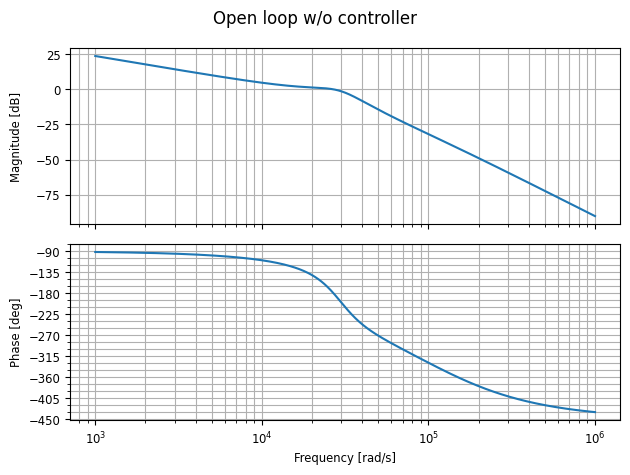

In [17]:
wc = 2 * np.pi * 1200  # fg*h < fc < fLCL
PM = 60  # higher damping
sc = 1j * wc

CPR = 1
OLpre = CPR * Gp  # Open loop without controller
magOL = abs(ctrl.evalfr(OLpre, sc))
phOL = np.angle(ctrl.evalfr(OLpre, sc)) * 180 / np.pi  # degrees

plt.figure(1)
ctrl.bode_plot(OLpre, dB=True)
plt.grid(True)
plt.suptitle('Open loop w/o controller')


In [6]:

print("=== w/o controller ===")
print(f"cut frequency: {sc} rad/s,\nOpenLoop magnitude and phase: {magOL}, {phOL}, \nphase margin: {phOL + 180}")
print("======================")

=== w/o controller ===
cut frequency: 7539.822368615503 rad/s,
OpenLoop magnitude and phase: 2.194510968966903, -104.161811241557, 
phase margin: 75.838188758443


Observa-se que o sistema é instável em malha fechada devido à margem de fase ser de -1.19°. Para obter um sistema estável em malha fechada, deve-se garantir que a fase do sistema em malha aberta, na frequência de corte, seja maior que -180° por um valor que é a margem de fase. Além disso, é necessário que o conversor sintetize sinais de corrente senoidais com erro nulo de regime permanente para a 1ª, 3ª e 7ª componentes harmônicas da frequência nominal da rede. 

Portanto, um controlador multi-ressonante será sintonizado nas frequências de 60Hz, 180Hz e 420Hz visando assegurar síntese de correntes senoidais com erro nulo em regime permanente dessas frequências, pois se $|OL(j\omega)| = +\infty$, então $|MF(j\omega)| = 1$, considerando que $MF(j\omega) = \frac{OL(j\omega)}{1 + OL(j\omega)}$, onde $MF(j\omega)$ é a função de transferência do sistema em malha fechada.

Também é possível impor a frequência de corte e a margem de fase desejadas para o sistema compensado em malha aberta. 

Para tal, foi escolhida uma frequência de corte,$f_c$ de 1200Hz.

Visando uma síntese de corrente satisfatória até a 20ª harmônica, bem como garantir uma atenuação no efeito da ressonância do filtro LCL por ser aproximadamente duas vezes menor que o mínimo valor de frequência da faixa de ressonância do filtro. 

A margem de fase ($\delta _m$) adotada para o projeto foi de 60° visando um máximo amortecimento.

A função de transferência do controlador proporcional ressonante é definida como 
$$
C_{PR}(s) = k_p + \frac{k_p}{T_r} \cdot \sum _{h=1,3,7} \frac{s}{s^2 + (hw_0)}
$$

Onde $w_0$ é a frequência angular da rede elétrica em rad/s.

A partir dos critérios definidos a seguir 

$$
\angle C_{PR}(j\omega _c) = \delta _m - \angle OL(j\omega _c)\\
|C_{PR}(j\omega _c)| \cdot |OL(j\omega _c)| = 1 
$$

Considerando que polinômios com potência par possuem parte imaginária nula e polinômios com potência ímpar possuem parte real nula quando $s = j\omega$. Ao substituir $C_{PR}(j\omega _c)$ e $OL(j\omega _c)$ nas equações acima, temos que

$$
k_p = \frac{|cos[\delta _m - \angle OL(j\omega _c)]|}{|OL(j\omega _c)|}\\
\frac{k_p}{T_r} = \frac{|sen[\delta _m - \angle OL(j\omega _c)]|}{|OL(j\omega _c)|} \cdot \frac{w_c^2 - (hw_0)^2}{w_c}
$$

Ao substituir ambas as expressões acima de volta na função de transferência do controlador proporcional ressonante $C_{PR}(s)$, obtemos:

$$
C_{PR}(s) = k_p + k_{i-c}\sum _{h=1,3,7} k_{ih - c} \cdot \frac{s}{s^2 + (hw_0)^2}
$$
onde:
$$
k_{i-c} = \frac{1}{3} \cdot \frac{|sen[\delta _m - \angle OL(j\omega _c)]|}{|OL(j\omega _c)|}\\
k_{ih-c} = \frac{\omega _c^2 - (h\omega _0)^2}{\omega _c},h=1,3,7
$$

Substituindo os valores de 𝛿𝑚, 𝜔𝑐 e 𝜔0 nas devidas expressões e realizando as operações algébricas necessárias, os ganhos do controlador proporcional ressonante foram calculados e possuem os seguintes valores:

$$
k_p = 0.4384\\
k_{i-c} = 0.0415\\
k_{i1-c} = 7.521\cdot 10^3\\
k_{i3-c} = 7.3702\cdot 10^3\\
k_{i7-c} = 6.6162\cdot 10^3\\
$$
Dessa forma, a função de transferência do controlador, $C_{PR}(s)$, fica:

In [7]:
# Resonant gain for h=1
R1_nd = ctrl.TransferFunction([1, 0], [1, 0, (1 * wg)**2])
R3_nd = ctrl.TransferFunction([1, 0], [1, 0, (3 * wg)**2])
R7_nd = ctrl.TransferFunction([1, 0], [1, 0, (7 * wg)**2])

# Proportional gain
kpc = abs(np.cos((PM - phOL - 180) * np.pi / 180)) / magOL  # sets 'wc' as the gain crossover freq (cutoff freq)

# ki per resonant element:
ki_c = abs(np.sin((PM - phOL - 180) * np.pi / 180)) / magOL / 3
ki1_c = (wc * wc - 1 * 1 * wg * wg) / wc
ki3_c = (wc * wc - 3 * 3 * wg * wg) / wc
ki7_c = (wc * wc - 7 * 7 * wg * wg) / wc

CPR = kpc + ki_c * ki1_c * R1_nd + ki_c * ki3_c * R3_nd + ki_c * ki7_c * R7_nd
CPR

TransferFunction(array([4.38382999e-01, 8.91590729e+02, 3.67593609e+06, 5.13101061e+09,
       4.41853932e+12, 3.12951267e+15, 5.54982137e+17]), array([1.00000000e+00, 0.00000000e+00, 8.38521590e+06, 0.00000000e+00,
       1.00791758e+13, 0.00000000e+00, 1.26597550e+18]))

O diagrama de bode de 𝐶𝑃𝑅(𝑠) é ilustrado pela figura a seguir:

=== ControllerPhase ===
-15.838188758442982


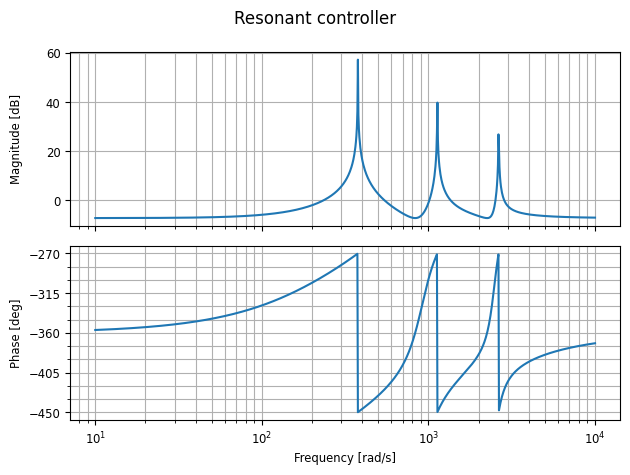

In [8]:
plt.figure(2)
ctrl.bode_plot(CPR, dB=True)
plt.grid(True)
plt.suptitle('Resonant controller')
print("=== ControllerPhase ===")
print(np.angle(ctrl.evalfr(CPR, sc)) * 180 / np.pi)
print("=======================")

Observamos as múltiplas ressonâncias (picos de ganho) nas específicas frequências de 377 𝑟𝑎𝑑/𝑠 (60 𝐻𝑧), 1130,97 𝑟𝑎𝑑/𝑠 (180 𝐻𝑧) e 2638,7 𝑟𝑎𝑑/𝑠 (420 𝐻𝑧).

Ao colocar a função de transferência do controlador, 𝐶𝑃𝑅(𝑠), em cascata com a função de transferência da planta, 𝐺𝑝(𝑠), obtermos a função de transferência do sistema em malha aberta compensado. 𝑂𝐿(𝑠)

In [9]:
OL = CPR * OLpre
OL

TransferFunction(array([ 5.08197891e-12, -7.49149715e-07,  3.81262770e-03,  1.99750085e+03,
        4.08912505e+06,  1.67663279e+10,  2.33750330e+13,  2.01247836e+16,
        1.42342898e+19,  2.52309013e+21]), array([-3.81469727e-25, -4.43903605e-20,  2.43596959e-15,  3.76991058e-10,
        9.94107411e-06,  2.95663825e-01,  8.32111668e+01,  2.45647911e+06,
        9.99948114e+07,  2.94863666e+12,  1.25592682e+13,  3.70297835e+17,
        0.00000000e+00]))

A resposta em frequência do sistema em malha aberta considerando o controlador 𝐶𝑃𝑅(𝑠) já sintonizado na malha direta é ilustrado pela figura a seguir

=== With controller ===
1.0
-119.99999999999997


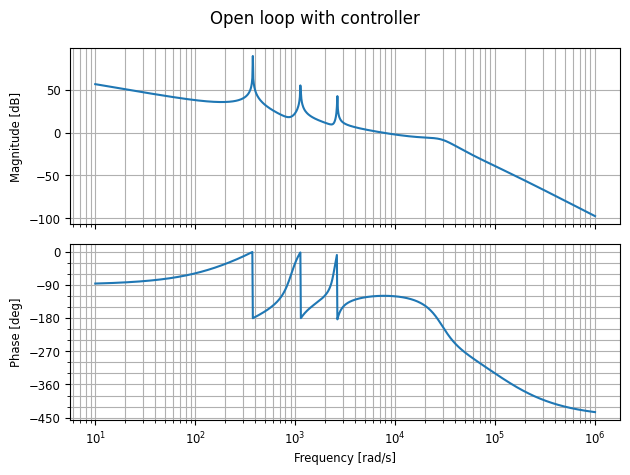

In [10]:

plt.figure(3)
ctrl.bode_plot(OL, dB=True)
plt.grid(True)
plt.suptitle('Open loop with controller')
print("=== With controller ===")
print(abs(ctrl.evalfr(OL, sc)))
print(np.angle(ctrl.evalfr(OL, sc)) * 180 / np.pi)
print("=======================")

Concluímos, portanto, que todas as especificações de projeto para o sistema de controle de corrente foram atendidas, visto que a margem de fase desejada ($\delta _m$=60°) foi alcançada na frequência de cruzamento determinada ($\omega _c$=7539,82 𝑟𝑎𝑑/𝑠=1200 𝐻𝑧). Vale destacar que, na frequência de chaveamento (1,5080∙105 𝑟𝑎𝑑/𝑠), a magnitude do sistema em malha aberta é igual a −49 𝑑𝐵.

Ao substituir os ganhos sintonizados em projeto no sistema simulado no ambiente do PSIM, a resposta para a síntese de corrente do conversor monofásico é ilustrada na figura a seguir.

Para avaliar a performance do controlador, simulamos o inversor operando em paralelo com uma rede poluída com as componentes 1, 3 e 7 da frequência fundamental. A forma de onda da tensão da rede simulada está ilustrada na figura a seguir.
<p align="center">
  <figure style="text-align: center;">
    <img src="images/psim_image4.jpeg" alt="psim image 3" style="width: 800px; height: auto;">
    <figcaption style="text-align: center;">Tensão da rede "poluída" com as componentes 1, 3 e 7.</figcaption>
  </figure>
</p>
 A resposta para a síntese de corrente do conversor monofásico é ilustrada na figura a seguir.
<p align="center">
  <figure style="text-align: center;">
    <img src="images/psim_image3.jpeg" alt="psim image 3" style="width: 800px; height: auto;">
    <figcaption style="text-align: center;">Curva de transientes de simulação do PSIM</figcaption>
  </figure>
</p>

Podemos observar que o controlador garantiu que o conversor sintetizasse as componentes 1, 3 e 7 com erro desprezível de regime permanente, visto o rastreamento de referência, bem como garantiu uma dinâmica razoavelmente rápida.
<p align="center">
  <figure style="text-align: center;">
    <img src="images/psim_image5.jpeg" alt="psim image 3" style="width: 800px; height: auto;">
    <figcaption style="text-align: center;">FFT da corrente do indutor 2 e da tensão da rede para uma janela de 10 ciclos em regime permanente</figcaption>
  </figure>
</p>
Analisando a FFT da corrente que flui através do indutor L2 e da tensão da rede Vg, observamos a correspondência de componentes nos dois espectros.